# Bootstrap Method for Two Samples 

This notebook will introduce bootstrap methods for comparison two groups.

In [1]:
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  

## Bootstrap method for two independent samples

The bootstrap method idea is simple: "If there is no difference between two treatments, a particular score is just as likely to end up in one group as in the other."

The first step is to transform the two samples we want to compare into others that share the mean.

Let us work with classes C and D.

We will test `Ho: mean(classC) = mean(classD)` without assuming equal variances. 

Let's generate values for classes C and D:

In [2]:
np.random.seed(123)
classC = np.random.normal(85, 3, 100)
classD = np.random.normal(90, 3, 95)

Notice that the means of `classC` and `classD` are different.

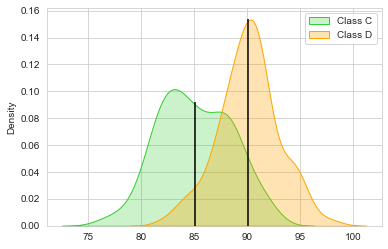

In [3]:
# Plotting the original variables classC and classD
ax=sns.kdeplot(x=classC, color='limegreen', shade=True, label='Class C')
ax.vlines(x=np.mean(classC), ymin=0, ymax=0.092, color='black')
ax=sns.kdeplot(x=classD, color='orange', shade=True, alpha=0.3, label='Class D')
ax.vlines(x=np.mean(classD), ymin=0, ymax=0.154, color='black')
plt.legend();

In [4]:
print('Mean of class C = %.2f' % np.mean(classC))
print('Mean of class D = %.2f' % np.mean(classD))

Mean of class C = 85.08
Mean of class D = 90.07


Notice that the number of students in each class is also different.

In [5]:
print('Lenght of class C =', len(classC))
print('Lenght of class D =', len(classD))

Lenght of class C = 100
Lenght of class D = 95


Let's transform the original samples into others that share their means.

In [6]:
def combined_mean(sample1, sample2):
    '''
    It concatenates sample1 with sample2
    and returns the combined mean.
    '''
    x = np.concatenate((sample1, sample2))
    return(np.mean(x))

In [7]:
cmean = combined_mean(classC, classD)
print('Mean of combined sample = %.2f' % cmean)

Mean of combined sample = 87.51


Creating classCt (class C transformed) and classDt (class D transformed)

In [8]:
classCt = classC - np.mean(classC) + cmean
classDt = classD - np.mean(classD) + cmean

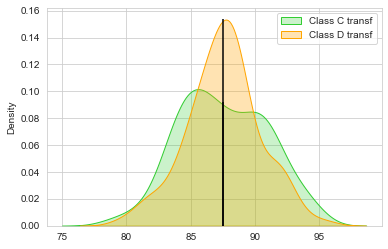

In [9]:
ax=sns.kdeplot(x=classCt, shade=True, color='limegreen', label='Class C transf')
ax.vlines(x=np.mean(classCt), ymin=0, ymax=0.092, color='black')
ax=sns.kdeplot(x=classDt, shade=True, color='orange', alpha=0.3, label='Class D transf')
ax.vlines(x=np.mean(classDt), ymin=0, ymax=0.154, color='black')

plt.legend();

In [10]:
print('Mean of shifted class C = %.2f' % np.mean(classCt))
print('Mean of shifted class D = %.2f' % np.mean(classDt))

Mean of shifted class C = 87.51
Mean of shifted class D = 87.51


`generateSamples` is the function for generating samples WITH replacement.

In [11]:
def generateSamples(sample_data, num_samples=10000, sample_size=100):
    '''
    It returns a DataFrame where each column is a sample (with replacement).
    '''
    col = ['S'+str(k) for k in range(num_samples)]
    samp = np.random.choice(sample_data, replace=True, size=sample_size*num_samples)
    df = pd.DataFrame(samp.reshape(sample_size, num_samples), columns=col)
    return(df)  

Let's generate two DataFrames of generated samples with replacement: one for `classCt` and the other for `classDt`

In [12]:
df_C = generateSamples(classCt, num_samples=10000, sample_size=50)
df_D = generateSamples(classDt, num_samples=10000, sample_size=50)

### Statistic: difference of means

`dMeans = mean1 - mean2`

`dMeans` is our statistic. It has the original data mean differences.

In [13]:
dMeans = np.mean(classC) - np.mean(classD)

We can calculate the sample distribution of the differences of means using the two DataFrames: `df_C` and `df_D`

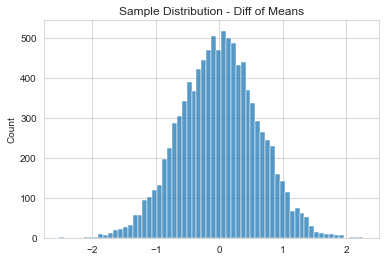

In [14]:
sample_distribution_dMeans = df_C.mean() - df_D.mean()
sns.histplot(x=sample_distribution_dMeans).set(title='Sample Distribution - Diff of Means');

In [15]:
def getpValue(sample_distribution, obs_value, alternative='two-sided'):
    '''
    It returns the p-value.
    sample_distribution: the sample distribution
    obs_value:           observed value 
    alpha:               significance level
    alternative:         one of the three values: 'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        if obs_value < np.mean(sample_distribution): 
            p_val = 2*ecdf(obs_value)
        else: 
            p_val = 2*(1-ecdf(obs_value)) 
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [16]:
def hyp_test(sample_value, sample_distribution, alpha=0.05, alternative='two-sided'):
    '''
    Bootstrap method for two-samples hypothesis test.
    sampl_value:        observed value calculated from the sample
    sampl_distribution: sample distribution calculated from the sample
    alpha:              significance level
    alternative:        one of the three values: 'two-sided', 'smaller', and 'larger'
    '''
    print('--- Bootstrap Hypothesis Test ---')
    sns.kdeplot(x=sample_distribution, color='lightskyblue', shade=True, alpha=0.4)  # plotting the sample distribution
    plt.axvline(x=sample_value, ymin=0, ymax= 0.03, color='black', linewidth=6)      # plotting the statistic 
    plt.title('Sampling Distribution')
    p_val = getpValue(sample_distribution, sample_value, alternative)
    if alternative=='two-sided':        # plotting the graph with two critical regions
        cv1 = np.round(np.percentile(sample_distribution, (alpha/2)*100),2)          # left critical value    
        cv2 = np.round(np.percentile(sample_distribution, 100-(alpha/2)*100),2)      # right critical value    
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
    elif alternative=='smaller':        # plotting the graph with left critical region
        cv1 = np.round(np.percentile(sample_distribution, alpha*100),2)              # left critical value
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    else:                               # plotting the graph with right critical region
        cv2 = np.round(np.percentile(sample_distribution, 100-alpha*100),2)          # right critical value
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('Observed Value = %.2f\tp-value = %.4f' %(sample_value, p_val))  

--- Bootstrap Hypothesis Test ---
Observed Value = -4.99	p-value = 0.0000


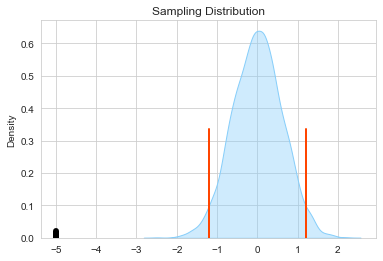

In [17]:
hyp_test(dMeans, sample_distribution_dMeans)

### Statistic: difference of medians

Let's use, statistic = median1 - median2

`dMedians` is our statistic. It has the original data median differences.

In [18]:
dMedians = np.median(classC) - np.median(classD) 

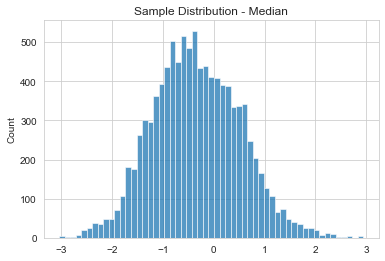

In [19]:
sample_distribution_dMedians = df_C.median() - df_D.median()
sns.histplot(x=sample_distribution_dMedians).set(title='Sample Distribution - Median');

--- Bootstrap Hypothesis Test ---
Observed Value = -5.44	p-value = 0.0000


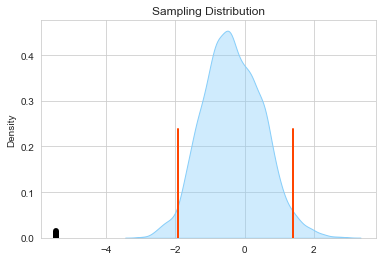

In [20]:
hyp_test(dMedians, sample_distribution_dMedians)

### Statistic: t-test

The following function calculates the `t-statistic` for the original two samples.

In [21]:
def t(sample1, sample2):
    n=len(sample1)
    m=len(sample2)
    denom=np.sqrt(np.var(sample1)/n+np.var(sample2)/m)
    return((np.mean(sample1)-np.mean(sample2))/denom)

In [22]:
t = t(classC, classD)

Let's define a function for calculating the sample distribution `t` using both DataFrames.

In [23]:
def createSampleDistributionT(df1, df2):
    '''
    It calculates the t statistic for all
    columns in both DataFrames.
    '''
    n=df1.shape[0]
    m=df2.shape[0]
    denom=np.sqrt(df1.var()/n + df2.var()/m)
    return(list((df1.mean()-df2.mean())/denom))

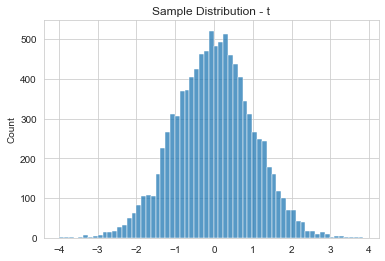

In [24]:
sample_distribution_t = createSampleDistributionT(df_C, df_D)
sns.histplot(x=sample_distribution_t).set(title='Sample Distribution - t');

--- Bootstrap Hypothesis Test ---
Observed Value = -11.22	p-value = 0.0000


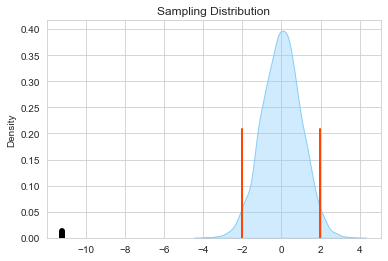

In [25]:
hyp_test(t, sample_distribution_t)

### Summarizing the procedure

In [26]:
class boot():
    '''
    Class for bootstrap method.
    '''

    def generateSamples(self, sample_data, num_samples=10000, sample_size=100):
        '''
        It returns a DataFrame where each column is a sample (with replacement).
        '''
        col = ['S'+str(k) for k in range(num_samples)]
        samp = np.random.choice(sample_data, replace=True, size=sample_size*num_samples)
        df = pd.DataFrame(samp.reshape(sample_size, num_samples), columns=col)
        return(df)   

        
    def getpValue(self, sample_distribution, obs_value, alternative='two-sided'):
        '''
        It returns the p-value.
        sample_distribution: the sample distribution
        obs_value:           observed value 
        alpha:               significance level
        alternative:         one of the three values: 'two-sided', 'smaller', or 'larger'    
        '''
        ecdf = ECDF(sample_distribution) 
        if alternative=='two-sided':
            if obs_value < np.mean(sample_distribution): 
                p_val = 2*ecdf(obs_value)
            else: 
                p_val = 2*(1-ecdf(obs_value)) 
        elif alternative=='smaller':
            p_val = ecdf(obs_value)
        else:
            p_val = 1-ecdf(obs_value)
        return(p_val)    


    def hyp_test(self, sample_value, sample_distribution, alpha=0.05, alternative='two-sided'):
        '''
        Method for two-samples hypothesis test.
        sampl_value:        observed value calculated from the sample
        sampl_distribution: sample distribution calculated from the sample
        alpha:              significance level
        alternative:        one of the three values: 'two-sided', 'smaller', and 'larger'
        '''
        # plotting the sample distribution
        sns.kdeplot(x=sample_distribution, color='lightskyblue', shade=True, alpha=0.4)  
        plt.title('Sampling Distribution')
        # plotting the statistic
        plt.axvline(x=sample_value, ymin=0, ymax= 0.03, color='black', linewidth=6)      
        # calculating the p-value
        p_val = self.getpValue(sample_distribution, sample_value, alternative)
        # plotting the graph with two critical regions
        if alternative=='two-sided':                        
            cv1 = np.round(np.percentile(sample_distribution, (alpha/2)*100),2)          # left critical value   
            cv2 = np.round(np.percentile(sample_distribution, 100-(alpha/2)*100),2)      # right critical value 
            plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
            plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        # plotting the graph with left critical region
        elif alternative=='smaller':                        
            cv1 = np.round(np.percentile(sample_distribution, alpha*100),2)              # left critical value
            plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        # plotting the graph with right critical region
        else:                                               
            cv2 = np.round(np.percentile(sample_distribution, 100-alpha*100),2)          # right critical value
            plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        print('Observed Value = %.2f\tp-value = %.4f' %(sample_value, p_val))  

In [27]:
class boot_2iHT(boot):
    '''
    Class for two-independent hypothesis test with bootstrap method.
    '''

    def __init__(self, sample1, sample2, num_samples=10000, sample_size=100):
        '''
        We want to compare sample1 with sample2. 
        They are independent, they should have similar length. 
        '''
        self.sample1 = np.array(sample1)
        self.sample2 = np.array(sample2)
        cmean = self.combined_mean()
        sample1t = self.sample1 - np.mean(self.sample1) + cmean
        sample2t = self.sample2 - np.mean(self.sample2) + cmean
        self.df1 = self.generateSamples(sample1t, num_samples, sample_size)
        self.df2 = self.generateSamples(sample2t, num_samples, sample_size)


    def combined_mean(self):
        '''
        It concatenates sample1 with sample2
        and returns the combined mean.
        '''
        x = np.concatenate((self.sample1, self.sample2))
        return(np.mean(x))
        

    def t(self):
        n=len(self.sample1)
        m=len(self.sample2)
        denom=np.sqrt(np.var(self.sample1)/n+np.var(self.sample2)/m)
        return((np.mean(self.sample1)-np.mean(self.sample2))/denom)


    def createSampleDistributionT(self):
        '''
        It calculates the t statistic for all
        columns in both DataFrames.
        '''
        n=self.df1.shape[0]
        m=self.df2.shape[0]
        denom=np.sqrt(self.df1.var()/n + self.df2.var()/m)
        return(list((self.df1.mean()-self.df2.mean())/denom))


    def boot_2i(self, stat='mean', alpha=0.05, alternative='two-sided'):    
        '''
        '''
        print('---Bootstrap 2 Independent Hypothesis Test---')
        print('     Sample 1 \t Sample 2')
        print('Mean:  %.2f \t %.2f' %(np.mean(self.sample1), np.mean(self.sample2)))
        print(' Var:  %.2f \t %.2f' %(np.var(self.sample1), np.var(self.sample2)))
        print('   n:  %i \t %i' %(len(self.sample1), len(self.sample2)))
        sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
        if stat=='mean':
            dMeans = np.mean(self.sample1) - np.mean(self.sample2)                  # computing the statistic 
            sample_distribution_dMeans = self.df1.mean() - self.df2.mean()          # computing the sample distribution
            self.hyp_test(dMeans, sample_distribution_dMeans, alpha=alpha, alternative=alternative)
        elif stat=='median':
            dMedians = np.median(self.sample1) - np.median(self.sample2)            # computing the statistic 
            sample_distribution_dMedians = self.df1.median() - self.df2.median()    # computing the sample distribution
            self.hyp_test(dMedians, sample_distribution_dMedians, alpha=alpha, alternative=alternative)
        elif stat=='t':
            t = self.t()                                                            # computing the statistic 
            sample_distribution_t = self.createSampleDistributionT()                # computing the sample distribution
            self.hyp_test(t, sample_distribution_t, alpha=alpha, alternative=alternative)

The first step is the initialization; it computes all the samples needed for calculating any sampling distribution.

In [28]:
two = boot_2iHT(classC, classD)

---Bootstrap 2 Independent Hypothesis Test---
     Sample 1 	 Sample 2
Mean:  85.08 	 90.07
 Var:  11.46 	 7.90
   n:  100 	 95
Observed Value = -4.99	p-value = 0.0000


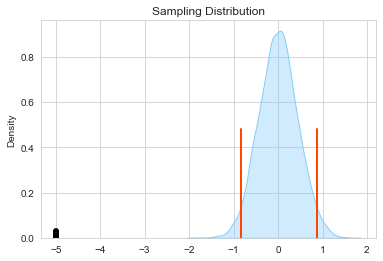

In [29]:
# Using the difference of means as statistic:
two.boot_2i('mean')

---Bootstrap 2 Independent Hypothesis Test---
     Sample 1 	 Sample 2
Mean:  85.08 	 90.07
 Var:  11.46 	 7.90
   n:  100 	 95
Observed Value = -5.44	p-value = 0.0000


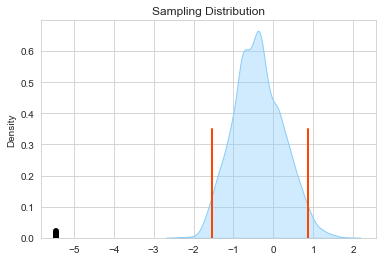

In [30]:
# Using the difference of medians as statistic:
two.boot_2i('median')

---Bootstrap 2 Independent Hypothesis Test---
     Sample 1 	 Sample 2
Mean:  85.08 	 90.07
 Var:  11.46 	 7.90
   n:  100 	 95
Observed Value = -11.22	p-value = 0.0000


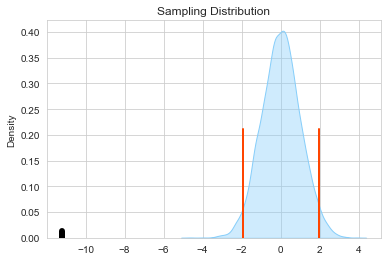

In [31]:
# Using the t statistic:
two.boot_2i('t')

## Bootstrap method for two paired samples

Let us generate some data.

In [32]:
np.random.seed(12)
grade_before = np.random.normal(85.5, 3, 80)
grade_after  = np.random.normal(86,   4, 80)
grade_after2 = np.random.normal(90,   3, 80)

When working with paired data, we cannot break the link between the values. 

If Ho is true, there are no differences between both grades. 

Let's use the variables `grade_before` and `grade_after2`.

- Ho: mean_grade_after2  = mean_grade_before  or  mean_grade_after2 - mean_grade_before  = 0
- Ha: mean_grade_after2 != mean_grade_before  or  mean_grade_after2 - mean_grade_before != 0

### Analyzing `grade_before` - `grade_after`

In [33]:
# Creating a new variable: the difference between both grades
diff = grade_after - grade_before
test_stat = np.mean(diff)
test_stat

0.2188556942747198

In [34]:
dfp = generateSamples(diff, num_samples=10000, sample_size=60)
print(dfp.shape)
dfp.head()

(60, 10000)


,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S9990,S9991,S9992,S9993,S9994,S9995,S9996,S9997,S9998,S9999
0,5.555854,-4.742263,7.356028,7.751267,-3.010257,-6.020940,4.435685,-1.091366,5.318484,8.307010,...,1.422767,0.701950,4.827833,-7.882146,1.422767,-1.791829,-2.018773,4.827833,-3.010257,-2.543830
1,6.581256,-8.443577,-0.062033,5.866276,-6.276514,1.501823,-1.091366,-5.954265,0.701950,-2.564452,...,1.442666,-3.356870,-6.556706,-0.780952,0.701950,-5.954265,-6.020940,3.044160,-1.599588,1.976234
2,-2.437505,-2.285395,-12.277802,6.665117,-4.214334,-1.144405,-2.018773,4.203373,-6.276514,-0.215214,...,-6.690566,-1.358545,-2.337707,5.866276,-2.564452,6.665117,3.661147,-4.694316,4.203373,3.065269
3,3.065269,-4.742263,4.203373,6.888128,-6.579056,1.442666,-6.690566,-2.018773,2.959870,0.782269,...,1.442666,0.914136,-3.010257,6.581256,1.257829,4.879429,0.701950,-0.215214,-6.556706,-6.540633
4,3.315550,-1.091366,2.841362,2.841362,1.134582,1.100158,5.866276,-1.402172,-6.556706,-1.402172,...,-2.543830,3.315550,4.435685,1.134582,2.959870,-6.540633,-5.543383,-8.443577,0.017452,4.827833


In [35]:
def boot_mean(df):
    '''
    It calculates the mean for each col of df
    '''
    return(list(df.mean()))

--- Bootstrap Hypothesis Test ---
Observed Value = 0.22	p-value = 0.9990


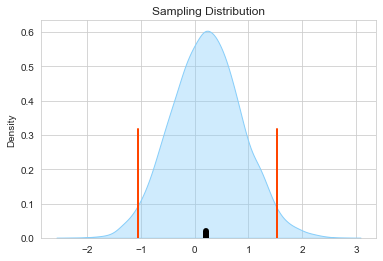

In [36]:
sample_distribution_p = boot_mean(dfp)
hyp_test(test_stat, sample_distribution_p)

In [37]:
diff2 = grade_after2 - grade_before
test_stat2 = np.mean(diff2)
test_stat2

4.069149842516363

In [38]:
dfp2 = generateSamples(diff2, num_samples=10000, sample_size=30)
print(dfp2.shape)
dfp2.head()

(30, 10000)


,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S9990,S9991,S9992,S9993,S9994,S9995,S9996,S9997,S9998,S9999
0,7.507750,13.096293,7.738211,1.591626,2.617735,2.722043,2.937403,-3.078381,4.283400,1.600897,...,-0.919736,6.791562,0.336661,3.708585,2.539579,-0.403437,-1.844746,-1.174273,7.957508,-3.078381
1,2.539579,3.767902,-3.078381,1.783475,4.233527,9.441196,7.738211,2.722043,6.791562,2.962475,...,8.512046,8.150276,-2.620154,3.494621,7.507750,2.832457,12.277091,-2.494695,2.962475,-0.028979
2,1.516716,12.277091,8.334529,8.437794,1.600897,10.347949,3.324760,0.336661,4.233527,8.150276,...,9.441196,-0.919736,6.462155,0.336661,1.236547,-1.844746,-5.055008,1.600897,-0.028979,2.722043
3,4.914252,4.346144,4.346144,6.192104,4.283400,-0.025646,-3.078381,3.954414,12.277091,0.096444,...,6.791562,-0.919736,4.346144,-1.844746,0.096444,5.890688,-1.548209,1.600897,8.150276,8.437794
4,19.279203,-0.028979,6.641396,4.024563,1.236547,5.890688,3.708585,9.441196,2.927282,10.347949,...,3.708585,1.600897,2.069146,-1.844746,5.560407,1.516716,11.245800,-0.403437,7.743748,4.314758


In [39]:
sample_distribution_p2 = boot_mean(dfp2)
sample_distribution_Ho2 = sample_distribution_p2 - np.mean(sample_distribution_p2)

--- Bootstrap Hypothesis Test ---
Observed Value = 4.07	p-value = 0.0000


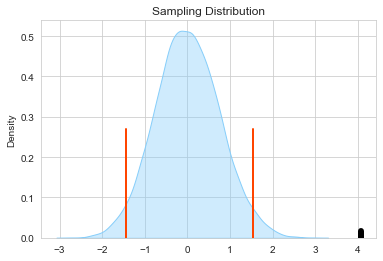

In [40]:
hyp_test(test_stat2, sample_distribution_Ho2)

### Summarizing

`TwoPairSamplesHT` is the new class for the two paired samples hypothesis test using the bootstrapping method.

In [41]:
class boot_2pHT(boot):
    '''
    '''

    def __init__(self, sampleb, samplea,  num_samples=10000, sample_size=100):
        '''
        We are working with paired samples: before (sampleb) and after (samplea). 
        We cannot break the link between both samples. 
        '''
        self.sampleb = np.array(sampleb)
        self.samplea = np.array(samplea)
        diff = samplea - sampleb
        self.df = self.generateSamples(diff, num_samples, sample_size)
        
    
    def boot_2p(self, stat='mean', alpha=0.05, alternative='two-sided'):    
        '''
        '''
        print('---Bootstrap 2 Paired Hypothesis Test---')
        print('     Sample before   \t Sample after')
        print('Mean:    %.2f   \t %.2f' %(np.mean(self.sampleb), np.mean(self.samplea)))
        print(' Var:    %.2f   \t %.2f' %(np.var(self.sampleb), np.var(self.samplea)))
        print('   n:    %i    \t\t %i' %(len(self.sampleb), len(self.samplea)))
        if stat=='mean':
            dMeans = np.mean(self.samplea) - np.mean(self.sampleb)                  # computing the statistic 
            sample_distribution_dMean = self.df.mean()                              # computing the sample distribution
            # computing the sample distribution under Ho
            sample_distribution_Ho = sample_distribution_dMean - np.mean(sample_distribution_dMean)          
            hyp_test(dMeans, sample_distribution_Ho, alpha=alpha, alternative=alternative)
        elif stat=='median':
            dMedian = np.median(self.samplea) - np.median(self.sampleb)             # computing the statistic 
            sample_distribution_dMedian = self.df.median()                          # computing the sample distribution
            # computing the sample distribution under Ho
            sample_distribution_Ho = sample_distribution_dMedian - np.mean(sample_distribution_dMedian)            
            hyp_test(dMedian, sample_distribution_Ho, alpha=alpha, alternative=alternative)
        

In [42]:
MyP = boot_2pHT(grade_before, grade_after)

---Bootstrap 2 Paired Hypothesis Test---
     Sample before   	 Sample after
Mean:    85.23   	 85.45
 Var:    10.12   	 17.78
   n:    80    		 80
--- Bootstrap Hypothesis Test ---
Observed Value = 0.22	p-value = 0.6706


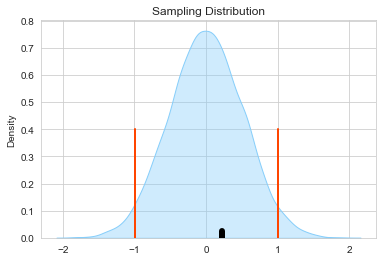

In [43]:
MyP.boot_2p('mean')

---Bootstrap 2 Paired Hypothesis Test---
     Sample before   	 Sample after
Mean:    85.23   	 85.45
 Var:    10.12   	 17.78
   n:    80    		 80
--- Bootstrap Hypothesis Test ---
Observed Value = 0.22	p-value = 0.8704


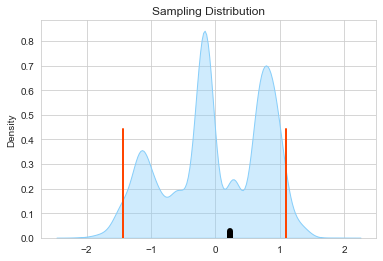

In [44]:
MyP.boot_2p('median')

In [45]:
MyP_2 = boot_2pHT(grade_before, grade_after2)

---Bootstrap 2 Paired Hypothesis Test---
     Sample before   	 Sample after
Mean:    85.23   	 89.30
 Var:    10.12   	 9.34
   n:    80    		 80
--- Bootstrap Hypothesis Test ---
Observed Value = 4.07	p-value = 0.0000


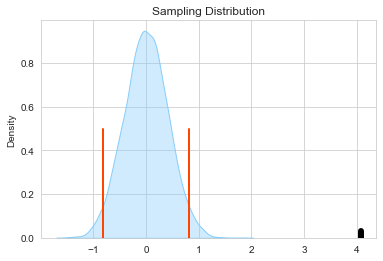

In [46]:
MyP_2.boot_2p('mean')

---Bootstrap 2 Paired Hypothesis Test---
     Sample before   	 Sample after
Mean:    85.23   	 89.30
 Var:    10.12   	 9.34
   n:    80    		 80
--- Bootstrap Hypothesis Test ---
Observed Value = 3.96	p-value = 0.0000


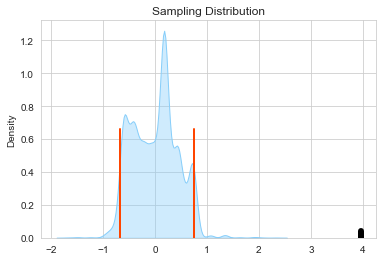

In [47]:
MyP_2.boot_2p('median')

References:
- Davison, A.C., Hinkley, D.V. (1997) Bootstrap Methods and their Applications, chapter 4, Cambridge: Cambridge University Press.
- Bradley, E., Tibshirani, R.J. (1993) An Introduction to the Bootstrap. chapter 16, Boca Raton: Chapman & Hall/CRC.